# Importação

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification, pipeline

In [ ]:
# Importando os dados do arquivo CSV
dados_churn = pd.read_csv('beta_churn_com_texto.csv')

# Imprimindo as primeiras linhas para ter uma noção do dataset
dados_churn.head()

,ID,Nome,Idade,Gênero,Localização,Estado Civil,Número de Dependentes,Data de Início do Contrato,Data de Término do Contrato,Valor Mensal do Contrato,Tipo de Serviço,Duração Média das Chamadas,Volume de Dados,Número de Reclamações,Comentários
0,1,João Silva,35,Masculino,São Paulo/SP/São Paulo,Casado,2,2018-05-10,NaN,79.99,Telefonia Móvel,4.5,2.3 GB,2,O serviço de internet tem sido instável. Estou...
1,2,Maria Santos,28,Feminino,Rio de Janeiro/RJ/Rio de Janeiro,Solteiro,0,2019-03-15,NaN,109.99,Internet,NaN,-,0,Estou satisfeita com o serviço. A velocidade d...
2,3,Carlos Oliveira,42,Masculino,Belo Horizonte/MG/Minas Gerais,Casado,1,2020-01-20,2021-06-30,139.99,Internet,NaN,-,1,Tive problemas com a fatura deste mês. O valor...
3,4,Ana Pereira,55,Feminino,Porto Alegre/RS/Rio Grande do Sul,Viúvo,0,2017-09-01,NaN,159.99,Telefonia Fixa,6.2,NaN,-,Sem reclamações até o momento. O serviço tem a...
4,5,Paulo Rodrigues,41,Masculino,Brasília/DF,Divorciado,3,2019-11-12,2022-01-05,99.99,TV a Cabo,NaN,-,0,O canal de esportes não está funcionando corre...


# Limpeza

In [3]:
# Imprimindo número de observações e variáveis para entender a dimensão do conjunto de dados
dados_churn.shape

(102, 15)

In [4]:
# Excluindo a coluna Nome, pois a variável não será utilizada para as análises
# Excluindo a coluna ID, pois o dataframe já é indexado por padrão
dados_churn = dados_churn.drop(['ID', 'Nome'], axis=1)

In [5]:
# Como as colunas Duração Média das Chamadas e Volume de Dados apresentam valores ausentes dependendo do tipo do plano (telefonia móvel/fixa, internet e tv a cabo)
# Não as utilizaremos para as análises ou para a criação do modelo de previsão de churn, já que são informações que, muitas vezes, não teremos para determinados clientes
dados_churn = dados_churn.drop(['Duração Média das Chamadas', 'Volume de Dados'], axis=1)

In [6]:
# Vamos criar uma coluna de status para servir de flag e possibilitar que analisemos os clientes ativos e inativos separadamente
dados_churn['Status'] = ''
dados_churn.loc[dados_churn['Data de Término do Contrato'].isna(), 'Status'] = 'Ativo'
dados_churn.loc[dados_churn['Status'] == '', 'Status'] = 'Inativo'

In [7]:
# A coluna Data de Término do Contrato apresenta valores ausentes para clientes ativos
# Podemos resolver esse problema juntando as colunas Data de Início do Contrato e Data de Término de Contrato em uma única coluna, indicando a duração do contrato
dados_churn['Data de Início do Contrato'] = pd.to_datetime(dados_churn['Data de Início do Contrato'])
dados_churn['Data de Término do Contrato'] = pd.to_datetime(dados_churn['Data de Término do Contrato'])
dados_churn.loc[dados_churn['Data de Término do Contrato'].isna(), 'Data de Término do Contrato'] = pd.Timestamp.today()
dados_churn['Tempo de Contrato Ativo em Dias'] = (dados_churn['Data de Término do Contrato'] - dados_churn['Data de Início do Contrato']).dt.days
dados_churn = dados_churn.drop(['Data de Início do Contrato', 'Data de Término do Contrato'], axis=1)

RODEI O CÓDIGO ATÉ AQUI

In [8]:
# A coluna Número de Reclamações apresenta duplicidade na codificação de valores nulos (0 e -)
# Vamos padronizar usando o 0 para indicar valores nulos
dados_churn.loc[dados_churn['Número de Reclamações'] == '-', 'Número de Reclamações'] = '0'

In [9]:
# A coluna Número de Reclamações contém dados incorretos em algumas das suas linhas (exemplo: linha com índice 69)
# Esses valores incorretos, na verdade, pertencem à coluna de comentários. Vamos corrigir isso a seguir
mascara = (~dados_churn['Número de Reclamações'].str.isnumeric() & dados_churn['Número de Reclamações'].notna())
dados_churn.loc[mascara & dados_churn['Comentários'].isna(),
                'Comentários'] = dados_churn.loc[mascara & dados_churn['Comentários'].isna(), 'Número de Reclamações']
dados_churn.loc[mascara, 'Número de Reclamações'] = 0
dados_churn['Número de Reclamações'] = pd.to_numeric(dados_churn['Número de Reclamações'], errors='coerce')

In [10]:
# A coluna Localização contém informações redundantes (tanto a sigla como o nome completo da UF)
# Vamos aplicar uma transformação para deixar os dados mais intuitivos e simples de se trabalhar
def transformar_string_localizacao(string_localizacao):
    partes = string_localizacao.split('/')
    if len(partes) >= 2:
        return f'{partes[0]}, {partes[1]}'
dados_churn['Localização'] = dados_churn['Localização'].apply(transformar_string_localizacao)

# Análise Exploratória de Dados

In [11]:
# Vamos computar as estatísticas descritivas para entender o comportamento das diferentes variáveis quantitativas
dados_churn.describe()

,Idade,Número de Dependentes,Valor Mensal do Contrato,Número de Reclamações,Tempo de Contrato Ativo em Dias
count,102.000000,102.000000,102.000000,102.000000,102.000000
mean,34.176471,0.862745,120.872353,0.186275,1720.686275
std,5.829953,0.923180,27.217603,0.438954,618.993450
min,26.000000,0.000000,69.990000,0.000000,527.000000
25%,29.000000,0.000000,99.990000,0.000000,1115.750000
50%,33.000000,1.000000,109.990000,0.000000,1767.500000
75%,38.750000,2.000000,139.990000,0.000000,2306.000000
max,55.000000,3.000000,189.990000,2.000000,2855.000000


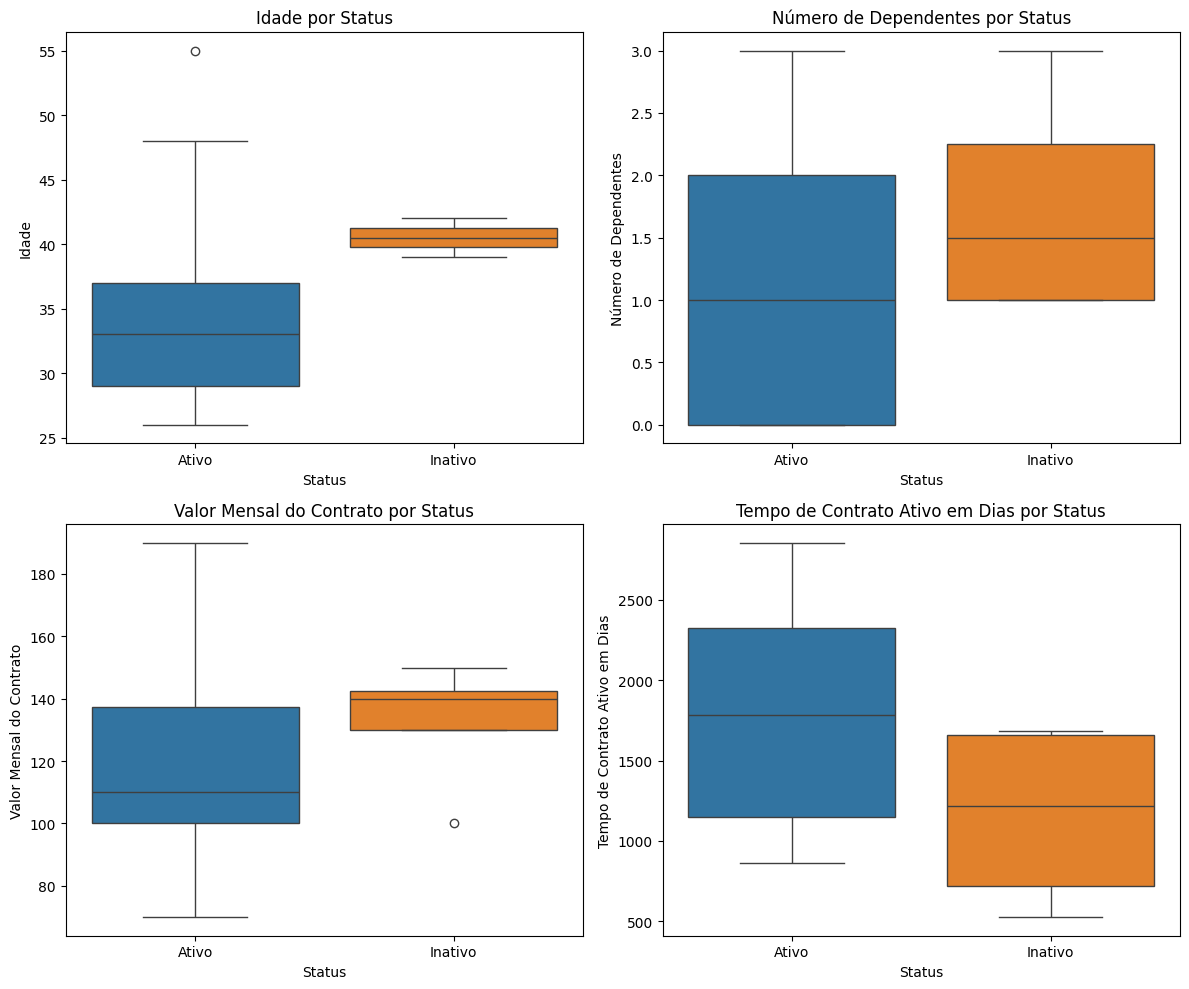

In [12]:
# Vamos visualizar o comportamento das diferentes variáveis quantitativas por meio de boxplots, segmentando por status

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

sns.boxplot(x='Status', y='Idade', data=dados_churn, ax=axes[0, 0], hue='Status')
axes[0, 0].set_title('Idade por Status')

sns.boxplot(x='Status', y='Número de Dependentes', data=dados_churn, ax=axes[0, 1], hue='Status')
axes[0, 1].set_title('Número de Dependentes por Status')

sns.boxplot(x='Status', y='Valor Mensal do Contrato', data=dados_churn, ax=axes[1, 0], hue='Status')
axes[1, 0].set_title('Valor Mensal do Contrato por Status')

sns.boxplot(x='Status', y='Tempo de Contrato Ativo em Dias', data=dados_churn, ax=axes[1, 1], hue='Status')
axes[1, 1].set_title('Tempo de Contrato Ativo em Dias por Status')

plt.tight_layout()
plt.show()

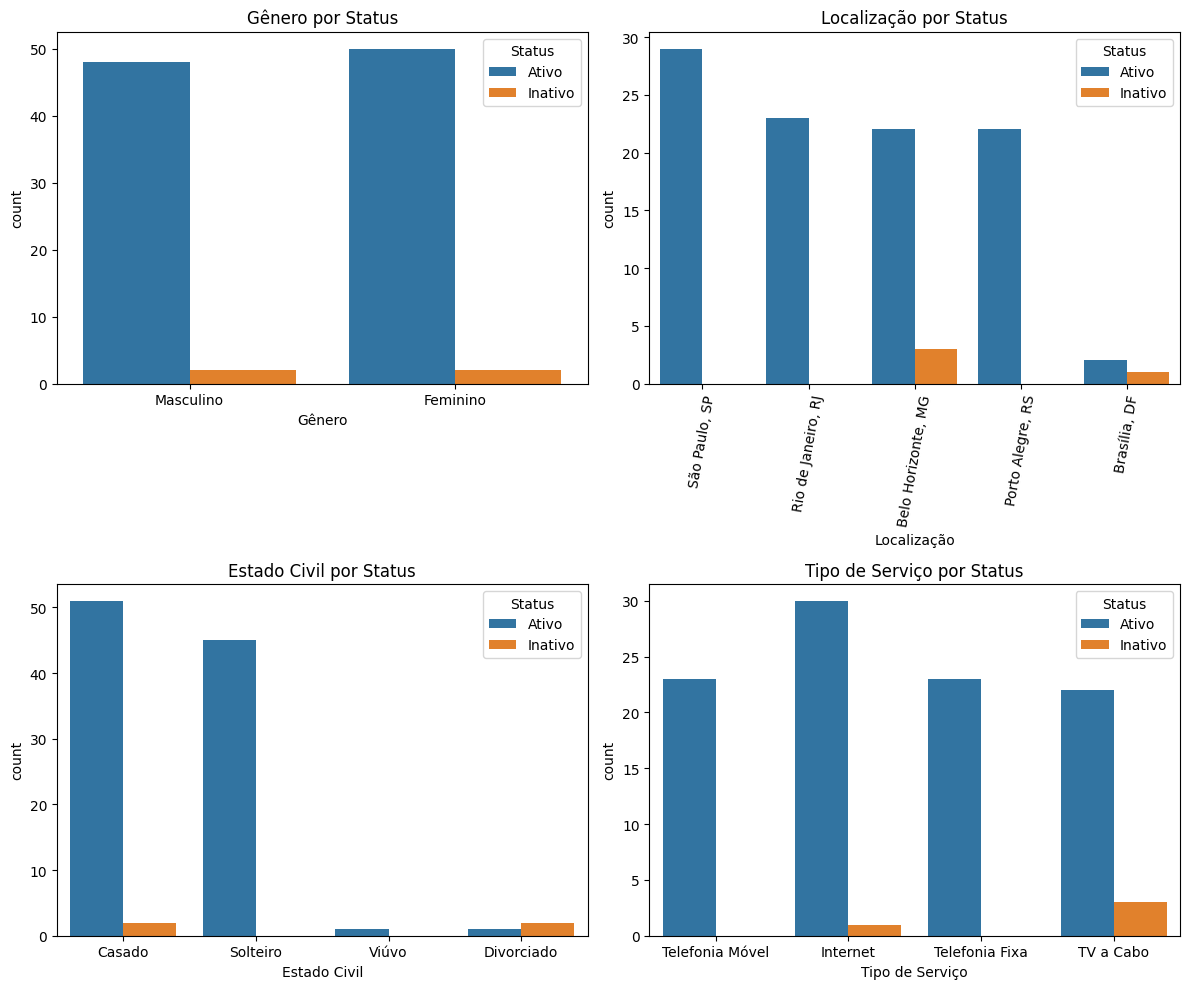

In [13]:
# Vamos visualizar o comportamento das diferentes variáveis qualitativas por meio de boxplots, segmentando por status

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

sns.countplot(x='Gênero', data=dados_churn, ax=axes[0, 0], hue='Status')
axes[0, 0].set_title('Gênero por Status')

sns.countplot(x='Localização', data=dados_churn, ax=axes[0, 1], hue='Status')
axes[0, 1].set_title('Localização por Status')
axes[0, 1].tick_params(axis='x', rotation=80)

sns.countplot(x='Estado Civil', data=dados_churn, ax=axes[1, 0], hue='Status')
axes[1, 0].set_title('Estado Civil por Status')

sns.countplot(x='Tipo de Serviço', data=dados_churn, ax=axes[1, 1], hue='Status')
axes[1, 1].set_title('Tipo de Serviço por Status')

plt.tight_layout()
plt.show()

# Modelo de NLP

In [14]:
# Carregando o modelo do HuggingFace
nome_modelo = 'tabularisai/multilingual-sentiment-analysis'
pipe = pipeline('text-classification', model=nome_modelo)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cpu


In [16]:
# Classificando os comentários
comentarios = dados_churn['Comentários'].to_list()
classificacoes = [pipe(comentario)[0]['label'] for comentario in comentarios]
dados_churn['Valência dos Comentários'] = classificacoes

# Identificando representatividade de cada valência
dados_churn['Valência dos Comentários'].value_counts()

,count
Valência dos Comentários,
Positive,36
Very Negative,34
Very Positive,16
Negative,11
Neutral,5


In [20]:
# Calculando valor anual salvo por identificação prévia de possível churn, usando a taxa de conversão de 50%
dados_neg = dados_churn.loc[((dados_churn['Valência dos Comentários'] == 'Negative') | (dados_churn['Valência dos Comentários'] == 'Very Negative')), :]
dados_neg_ativos = dados_neg.loc[dados_neg['Status'] == 'Ativo', 'Valor Mensal do Contrato'].sum()*0.5*12
float(dados_neg_ativos)

28257.48